In [54]:
#εισαγωγή βιβλιοθηκών - πακέτων
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight

nclass = 3
csv_file_path = 'https://raw.githubusercontent.com/kdemertzis/EKPA/refs/heads/main/Data/pcap_data.csv'


In [55]:
def loadDataset():
    # Put dataset path here !
    data = pd.read_csv(csv_file_path)

    X = data.drop('target', axis=1).values
    y = data['target'].values

    return X, y

In [ ]:
# -- LOAD DATA -----------------------------------------------------------------
X, y = loadDataset()

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Test data 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

# Train 70%, Validation%10
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, stratify=y_train)

train_data, train_labelp, val_data, val_labelp, test_data, test_labelp = X_train.astype(
    'float32'), y_train.astype('int32'),  X_val.astype('float32'), y_val.astype(
        'int32'),  X_test.astype('float32'), y_test.astype('int32')

In [57]:
# to_categorical
train_label = to_categorical(train_labelp, nclass)
val_label   = to_categorical(val_labelp,   nclass)
test_label  = to_categorical(test_labelp,  nclass)

print('train_data.shape=', train_data.shape)
print('test_data.shape=',  test_data.shape)
print('test_data.shape=',  val_data.shape)

#get the number of features
inshape=train_data.shape[1]

# Class balancing weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(
                                                      train_labelp),
                                                  y=train_labelp)


class_weights = {i: class_weights[i] for i in range(len(class_weights))}

train_data.shape= (10476, 25)
test_data.shape= (2994, 25)
test_data.shape= (1497, 25)


In [58]:
# -- CALLBACKS -----------------------------------------------------------------
earlyStopping = EarlyStopping(monitor='val_loss',
                              patience=30,
                              verbose=0,
                              mode='min')

modelCheckPoint = ModelCheckpoint('./savemodels/model5class.weights.{epoch:03d}-{val_acc:.4f}.hdf5.keras',
                                  save_best_only=True,
                                  monitor='val_acc',
                                  mode='max')

In [59]:
#συνάρτηση δημιουργίας και εκπαίδευσης νευρωνικού δικτύου
def create_and_train_model(input_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [60]:
#συνάρτηση αξιολόγησης μοντέλου και εκτύπωσης αποτελέσματων κατηγοριοποίησης
def evaluate_model(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    accuracy = classification_report(y_test, y_pred, output_dict=True)
    return accuracy['accuracy']

In [61]:
#συνάρτηση προσομοίωσης "λ" αρχιτεκτονικής με επανεκπαίδευση μετά από πλήθος ροών δεδομένων (streaming lambda architecture with periodic retraining)
def simulate_streaming_lambda_architecture(model, scaler, batch_size=500, retrain_every_batches=800, total_batches=8000):
    batch_counter = 0
    train_accuracies = []
    test_accuracies = []

    while batch_counter < total_batches:
        #φόρτωση συνόλου δεδομένων από csv αρχείο
        X, y = loadDataset()

        #τυποποίηση (standardize) δεδομένων
        X = scaler.transform(X)

        #κατάτμηση δεδομένων σε ροές (batches)
        for i in range(0, len(X), batch_size):
            batch_counter += 1
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            #εκπαίδευση μοντέλου με κάθε ροή δεδομένων
            model.train_on_batch(X_batch, y_batch)

            #περιοδική εκπαίδευση μοντέλου με όλα τα δεδομένα
            if batch_counter % retrain_every_batches == 0:
                #τμηματοποίηση δεδομένων σε σύνολα εκπαίδευσης και δοκιμών
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                #επανεκπαίδευση μοντέλου με όλα τα δεδομένα
                model = create_and_train_model(X_train.shape[1])
                model.fit(X_train, y_train, epochs=5, batch_size=64)  # Train for a few epochs

                #αποθήκευση των βαρών (weights) του μοντέλου για μελλοντική επανεκπαίδευση
                model.save('model_weights.keras')

                #αξιολόγηση του μοντέλου στα σύνολα εκπαίδευσης και δοκιμών
                train_accuracy = evaluate_model(model, X_train, y_train)
                test_accuracy = evaluate_model(model, X_test, y_test)

                train_accuracies.append(train_accuracy)
                test_accuracies.append(test_accuracy)

                print(f"Batch {batch_counter}, Training Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    return train_accuracies, test_accuracies

In [62]:
#εκκίνηση προσομοίωσης "λ" αρχιτεκτονικής με επανεκπαίδευση μοντέλου
model = create_and_train_model(inshape)
train_accuracies, test_accuracies = simulate_streaming_lambda_architecture(model, scaler)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6622 - loss: 0.7771
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8536 - loss: 0.4891
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8708 - loss: 0.4476
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8823 - loss: 0.4185
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8923 - loss: 0.4015
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 800, Training Accuracy: 0.9130, Test Accuracy: 0.9058
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6222 - loss: 0.8274
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8505 - loss: 0.4960
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8780 - loss: 0.4327
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8856 - loss: 0.4266
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8933 - loss: 0.3988
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 1600, Training Accuracy: 0.9157, Test Accuracy: 0.9035
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6447 - loss: 0.8077
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8436 - loss: 0.5044
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8631 - loss: 0.4616
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8806 - loss: 0.4348
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8899 - loss: 0.4060
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 2400, Training Accuracy: 0.9151, Test Accuracy: 0.9025
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6572 - loss: 0.7833
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8437 - loss: 0.4844
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8751 - loss: 0.4452
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8812 - loss: 0.4283
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8950 - loss: 0.4032
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 3200, Training Accuracy: 0.9151, Test Accuracy: 0.9051
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6350 - loss: 0.8030
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8511 - loss: 0.4792
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8703 - loss: 0.4430
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8891 - loss: 0.4185
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8909 - loss: 0.4129
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 4000, Training Accuracy: 0.9163, Test Accuracy: 0.9018
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6316 - loss: 0.8006
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8494 - loss: 0.4942
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8759 - loss: 0.4405
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8848 - loss: 0.4229
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8896 - loss: 0.4085
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 4800, Training Accuracy: 0.9163, Test Accuracy: 0.9051
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6279 - loss: 0.8230
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8451 - loss: 0.4892
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8728 - loss: 0.4374
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8877 - loss: 0.4171
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8904 - loss: 0.3955
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 5600, Training Accuracy: 0.9158, Test Accuracy: 0.9028
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6497 - loss: 0.8079
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8472 - loss: 0.4952
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8732 - loss: 0.4507
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8797 - loss: 0.4298
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8936 - loss: 0.4066
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 6400, Training Accuracy: 0.9166, Test Accuracy: 0.9058
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6203 - loss: 0.8294
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8492 - loss: 0.4866
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8754 - loss: 0.4480
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8848 - loss: 0.4216
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8971 - loss: 0.3988
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Batch 7200, Training Accuracy: 0.9141, Test Accuracy: 0.9051
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6417 - loss: 0.8020
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8474 - loss: 0.4840
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8730 - loss: 0.4487
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8809 - loss: 0.4262
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8890 - loss: 0.3961
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 8000, Training Accuracy: 0.9154, Test Accuracy: 0.9035


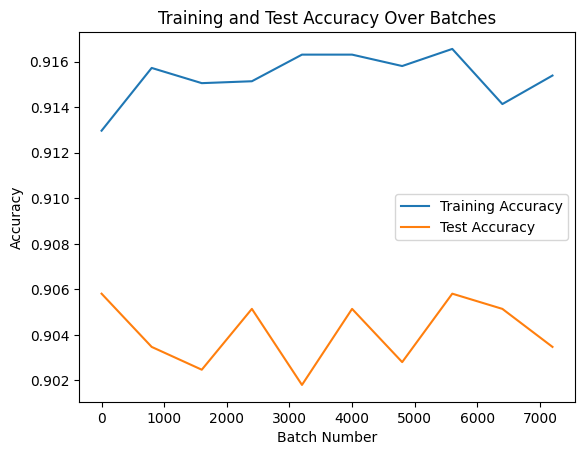

In [63]:
total_batches = 8000
retrain_every_batches = 800
#εκτύπωση γραφικής απεικόνισης ακρίβειας μοντέλου
plt.plot(range(1, total_batches+1, retrain_every_batches), train_accuracies, label='Training Accuracy')
plt.plot(range(1, total_batches+1, retrain_every_batches), test_accuracies, label='Test Accuracy')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Over Batches')
plt.legend()
plt.show()